<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 3: Notebook 5
## Final Model & Conclusions

---
## Section 1: Introduction
---

#### Problem Statement

In this study, I will use Naive Bayes and Random Forest models to classify posts in the Audio Engineering and Songwriting Subreddits, with the goal of helping a beginner songwriter and recordist determine where to find the most relevant and helpful information for their learning process.
<br>
<br>
With the leaps in accessible audio recording technology over the past decade, more young musicians are starting to both write and record their own music. In my experience, it’s more financially viable to learn to record yourself. However, there’s a steep learning curve, and learning from the experience of decades of recording and songwriting wisdom available online is a huge help.

#### Background

I've spent the last 15 years writing, producing, and recording music, and over that time, I came to learn two very important things: first, there's a wealth of valuable information available on the internet; and second, there's a wealth of misleading, not-so-valuable information on the internet. [Reddit](https://www.reddit.com) (and its many Subreddits) is an excellent source for both the valuable information and the not-so-valuable information. As someone who's navigated this tricky territory, I'd love to create a tool to help guide young songwriters and recordists to positive, trustworthy online communities where they can learn and develop their craft.
<br>
<br>
I chose to explore posts and build my **Multinomial Naive Bayes** and **Random Forest** classification models based on the following **Subreddits**:
* [r/audioengineering](https://www.reddit.com/r/audioengineering/): A community of audio engineers, technicians, builders, and musicians focused on providing tips and tricks for the amateur-to-professional recordist.
* [r/Songwriting](https://www.reddit.com/r/Songwriting/): A community of songwriters, musicians, and recordists focused on providing tips for writing music and feedback on original music.

---
## Section 2: Imports

---

**BELOW:** Importing Python libraries for processing and modeling my Subreddits.

In [1]:
# The basics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Pipeline and Gridsearch imports.
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.pipeline import Pipeline

# Estimator imports
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

# Token processing imports
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text

**BELOW:** Pulling in the cleaned CSV of my merged Subreddits.

In [2]:
subs_df = pd.read_csv('../data/subs_df_01.csv')

In [3]:
subs_df.head(2)

,subreddit,full_post
0,0,Help Identifying a Mic [https://www.youtube.co...
1,0,Import eq filters to t.racks dsp 4x4 mini from...


In [4]:
subs_df.isnull().sum()

subreddit    0
full_post    0
dtype: int64

---
## Section 3: Baseline Accuracy

---

This is the value to beat. If my model outperforms the prediction of the majority class (here `0`, or the Audio Engineering Subreddit) which has a baseline accuracy of `0.506725`, or $50.67\%$), I know it's heading in the right direction.

In [5]:
# Setting my X and y variables.
X = subs_df['full_post']
y = subs_df['subreddit']

In [6]:
y.value_counts(normalize = True)

1    0.506725
0    0.493275
Name: subreddit, dtype: float64

---
## Section 4: Multinomial Naive Bayes & CountVectorizer

---

Moreso than any other model, I was able to achieve an extremely close training and testing score using `CountVectorizer` in a Multinomial Naive Bayes model. Additionally, these scores were quite close to 1, indicating a high degree of accuracy and predictive power. Below, I've shown the steps I took, as well as the best hyperparameters that gave me this model. Training and Testing scores are found at the end of this section, accompanied by an analysis. Detailed modeling can be found in [Notebook 4](../code/04_eda_and_modeling.ipynb).

In [7]:
# Instantiating a train-test-split on my merged dataframe.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

In [8]:
cvec = CountVectorizer()
cvec.fit(X_train)
X_train_trans = cvec.transform(X_train)

# Transforming my X testing data using CountVectorizer for testing my model on unseen data.
X_test_trans = cvec.transform(X_test)

**BELOW:** Instantiating a pipeline, then fitting my Multinomial Naive Bayes model with the best parameters determined when tuning the model in Notebook 4.

In [9]:
# Instantiating a pipeline, and specifying Multinomial Naive Bayes as the estimator, and CountVectorizer as the transformer.
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('nb', MultinomialNB())
])

# Fitting my pipeline.
pipe.fit(X_train, y_train)

# Defining my list of best cvec hyperparameters.
pipe_params = {
    'cvec__max_features': [25_000],
    'cvec__min_df': [2],
    'cvec__stop_words': ['english'],
    'cvec__ngram_range': [(1,2)]
}

# Instantiating GridSearchCV on my cvec-transformed data.
gs = GridSearchCV(pipe, 
                  param_grid = pipe_params,
                  cv = 5,                   
                  n_jobs = 6) 

# Fitting the model to my training data.
gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('nb', MultinomialNB())]),
             n_jobs=6,
             param_grid={'cvec__max_features': [25000], 'cvec__min_df': [2],
                         'cvec__ngram_range': [(1, 2)],
                         'cvec__stop_words': ['english']})

---
---
**BEST MNB/CVEC MODEL SCORES:**

**Training Score: 0.973**

In [10]:
# Scoring the model on training data.
gs.score(X_train, y_train)

0.9727364040751901

**Testing Score: 0.956**

In [11]:
# Scoring the model on testing data. This is how it actually perfomed on unseen data.
gs.score(X_test, y_test)

0.9556798623063684

In [12]:
# Generating predictions.
preds = gs.predict(X_test)

# Saving confustion matrix values so I can plot them below.
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

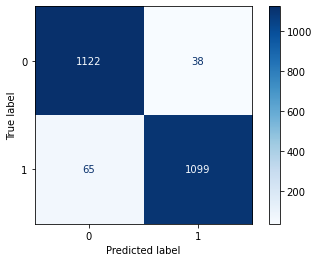

In [13]:
# Plotting a confusion matrix for my Naive Bayes/cvec gridsearch model.
plot_confusion_matrix(gs, X_test, y_test, cmap='Blues', values_format='d');

---

**Model Thoughts:**
- This Multinomial Naive Bayes model, using the `CountVectorizer` transformer, was my best performing model overall, with a training score of 0.973 and a testing score of 0.956. Though the training score is slightly higher than the testing score, the difference is marginal, meaning I can expect this model to perform well on unseen data.
- The difference between training and testing scores is minute, and both sets are performing with a high degree of accuracy. I'd be confident using this model to make predictions.
- After tuning hyperparameters in my pipeline, I determined that 25,000 max features, a `max_df` of 2, an `n_gram` range of `(1,2)`, and English stop words yielded the best result for this model. 
- Based on the confusion matrix above, misclassification is minimal - I only found 103 misclassified posts out of almost 2500 posts in my test set. I'm very happy with this performance!

---
---

`RandomForestClassifier` model scores and associated best hyperparameters for comparison to my Multinomial Naive Bayes model. Though the best scores displayed below are good, the Random Forest models were all overfit, testing a few percentage points higher on training data as compared to testing data.

In [14]:
rf_models_df = pd.read_csv('../data/random_forest_models.csv')
rf_models_df

,model,score,n_estimators,max_depth,max_features,ccp_alpha
0,Random Forest & TVEC 1,0.925671,100,25,auto,0
1,Random Forest & TVEC 2,0.926819,150,30,auto,0
2,Random Forest & TVEC 3,0.930550,200,35,auto,0
3,Random Forest & TVEC 4,0.933850,200,35,auto,0
4,Random Forest & CVEC 1,0.875592,50,6,NaN,0
5,Random Forest & CVEC 2,0.890658,100,8,NaN,0
6,Random Forest & CVEC 3,0.910890,75,15,auto,0
7,Random Forest & CVEC 4,0.925528,150,25,auto,0
8,Random Forest & CVEC 5,0.926962,100,35,auto,0


---
---


## Section 5: Visualization of Most Common Words

---

#### Graphing Most Frequently Occurring Words Across Both Subreddits

In [15]:
# Defining my own stop words, to be used in conjunction with the default English stop words.
my_stops = ['ve', 'don', 'good', 'bad', 'https', 'com', 'www', 'll', 'just', 'want', 'new', 'like', 'does',
            'feel', 'think', 'use', 'amp', 'x200b','let', 'got', 'know', 'really', 'way', 'song', 'songs', 'audio']

# Combining my stop words list with the default sklearn English stop word list.
# With guidance from this Kaggle post: https://www.kaggle.com/c/msk-redefining-cancer-treatment/discussion/37679
stops = text.ENGLISH_STOP_WORDS.union(my_stops)

In [16]:
# Instantiating a CountVectorizer with custom stop words and fitting/transforming to my X training data.
# With guidance from lesson 5.04.
cvec = CountVectorizer(stop_words = stops)
cvec.fit(X_train)
X_train_trans = cvec.transform(X_train)

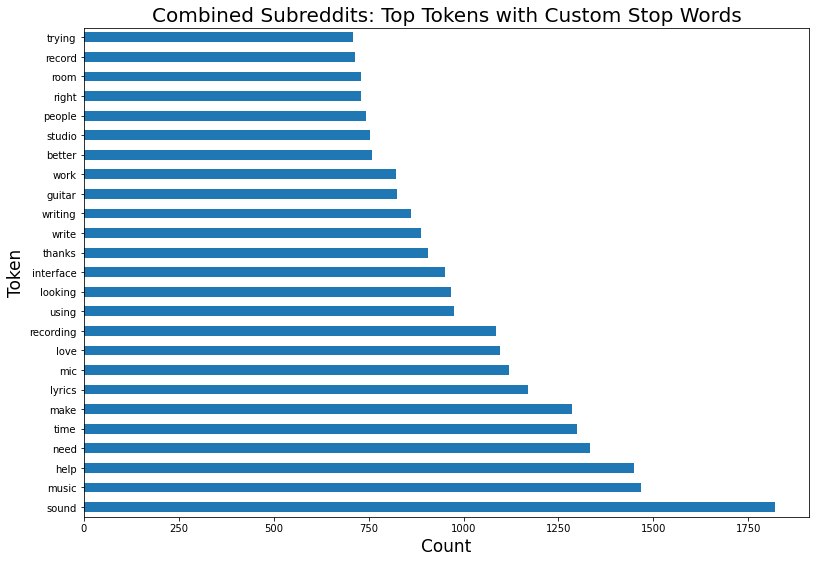

In [17]:
# Saving my training data to a dataframe using the pandas method 'todense()', and setting columns as my tokens from the cvec transformer.
X_train_df = pd.DataFrame(X_train_trans.todense(), columns = cvec.get_feature_names())

# Plotting most frequently occurring words in a bar chart.
plt.figure(figsize = (13, 9))
X_train_df.sum().sort_values(ascending = False).head(25).plot(kind = 'barh')
plt.xlabel('Count', size = 17)
plt.ylabel('Token', size = 17)
plt.title('Combined Subreddits: Top Tokens with Custom Stop Words', size = 20);

---

## Section 6: Conclusions & Final Thoughts

---

**Conclusions**
- Fundamentally, my Multinomial Naive Bayes model performed quite well on unseen data. Some considerations for scaling this model would be observing posts over a longer span of time, looking at trends in most frequent posters in each community, and examine the level of community interaction generated by each post.
- I was surprised to see how well my model differentiated between the Audio Engineering and Songwriting Subreddits - it correctly predicted which forum the post came from at a rate of $95.6\%$. I assumed there would be much more crossover in terminology, and while there is some, the audiences appear fairly different, at least in how they speak about their respective topics.
- The most common shared words across both Subreddits certainly make sense given the topics.
- Both forums are, socially speaking, positive communities based on sentiment analysis ([Notebook 3](../code/03_basic_eda.ipynb)). The Audio Engineering Subreddit had a slightly higher compound sentiment score of 0.488 (based on the mean compound sentiment generated with nltk's `SentimentIntensityAnalyzer`, which ranks the poitivity or negativity of text tokens on a scale of -1 to +1 [Lesson 5.03]). The Songwriting Subreddit also skewed positive, with a mean compound sentiment score of 0.327. Though the `SentimentIntensityAnalyzer` and `VADER` lexicon aren't perfect, these scores do suggest that both communities  post predominantly positive content. Positivity is a huge plus when learning something new, so I'm happy to see these results! Comments on posts were not considered in these scores, though I'd like to in a future version of this project, as I believe they could significantly impact these scores.
- My misclassification rate was very low!
- Given more time, I'd like to scrape more posts, including the comments on these posts, and see how that changes my model. While the original posts are all fairly positive, and are generally either seeking help or offering wisdom, I'm sure the comments have a wider range of sentiments, and so, may produce an interesting effect on my model.
<br>
<br>

**Actions**

- Let's expand this to more Subreddits! The more communities I pull from, the more my model can grow, and the better it can help direct beginners to the best Subreddit for their needs and goals.
- I'd like to scrape, and perform similar analysis on more "official" sources for recording and songwriting, such as [TapeOp](https://tapeop.com/) and [Sound On Sound](https://www.soundonsound.com/).